In [172]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go 
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from functools import reduce
import datetime as dt

#Validation
from sklearn.metrics import mean_squared_error
import math

#LSTM Model
from keras.layers import Dense,LSTM,Dropout
from keras.models import Sequential,Model
from tensorflow import keras
import keras
import pandas_datareader as pdr

import seaborn as sns
import matplotlib.pyplot as plt


In [173]:
close=pd.read_csv('data/close.csv')
adj_close=pd.read_csv('data/adj_close.csv')
open=pd.read_csv('data/open.csv')
high=pd.read_csv('data/open.csv')
low=pd.read_csv('data/low.csv')
volume=pd.read_csv('data/volume.csv')

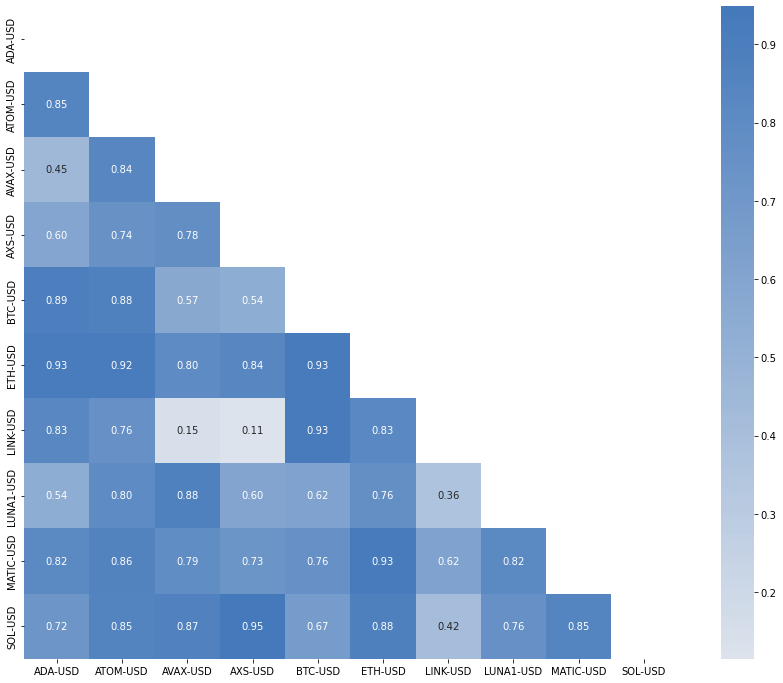

In [174]:
corrMatrix = close.corr()

mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

# Create a custom divergin palette
#cmap = sns.diverging_palette(250, 15, s=75, l=40,
#                            n=9, center="light", as_cmap=True)
cmap = sns.diverging_palette(10, 250, n=256)
plt.figure(figsize=(16, 12))
sns.heatmap(corrMatrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)
plt.savefig('corr.jpg')
plt.show()

In [175]:
dataframes = [close, adj_close, open, high, low, volume]
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)

C:\Users\renan\AppData\Local\Temp/ipykernel_24712/2867073563.py:2: FutureWarning: Passing 'suffixes' which cause duplicate columns {'BTC-USD_x', 'LINK-USD_x', 'ATOM-USD_x', 'SOL-USD_x', 'AXS-USD_x', 'LUNA1-USD_x', 'AVAX-USD_x', 'ETH-USD_x', 'ADA-USD_x', 'MATIC-USD_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Date'], how='outer'), dataframes)


In [176]:
#Prepare datasets per currency

def currency(curr): 
    df=df_merged[['Date',curr+'_x', curr+'_y']]
    df.columns = ['Date','Close', 'Adj_Close','Open','High', 'Low', 'Volume']
    df = df.dropna()
    df['Date'] = pd.to_datetime(df['Date'])
    #df = df.loc[df['Date'].dt.year >= 2020]
    #df = df.loc[df['Date'].dt.month >= 7]
    df = df.reset_index(drop=True)
    return df

ada=currency('ADA-USD')
atom=currency('ATOM-USD')
avax=currency('AVAX-USD')
axs=currency('AXS-USD')
btc=currency('BTC-USD')
eth=currency('ETH-USD')
link=currency('LINK-USD')
luna1=currency('LUNA1-USD')
matic=currency('MATIC-USD')
sol=currency('SOL-USD')

#Dictionary with crypto names and datasets
crypto_names = {'ADA-USD':ada, 
               'ATOM-USD':atom,
               'AVAX-USD':avax,
               'AXS-USD':axs,
               'BTC-USD':btc,
               'ETH-USD':eth,
               'LINK-USD':link,
               'LUNA1-USD':luna1,
               'MATIC-USD':matic,
               'SOL-USD':sol}

In [177]:
#DF preparing functions for Close and High, also splitting the training/test dataset
def lstm_close(curr):
    df=curr.reset_index()['Close']
    scaler=MinMaxScaler(feature_range=(0,1))
    df = np.array(df).reshape(-1,1)
    #df=scaler.fit_transform(np.array(df).reshape(-1,1))
    return scaler,df

#Split df using % of choice
def split_df(df):
    training_size=int(len(df)*0.95)
    test_size=len(df)-training_size
    train_data,test_data=df[0:training_size,:],df[training_size:len(df),:1]
    return train_data,test_data

#Using the provided data, create a dataset of sequential values using a timestep (number of days chosen)
def create_dataset(dataset, time_step):
    data_x, data_y = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        data_x.append(a)
        data_y.append(dataset[i + time_step, 0])
    return np.array(data_x), np.array(data_y)


In [184]:
#Macro function to predict the next 2 days for a certain coin.
#Returns list with the outputs for the 2 days
'''
Parameters:
name - String with the name of the coin
df - dataframe for the coin
days - how many days to use as basis for predicting (standard: 15)
epochs - how many epochs for the LSTM to run (standard: 20)

'''

def predict_coin(name,df,days=15,epochs=20):
    
    scaler,df1 = lstm_close(df)
    
    #Split dataframe in train test
    train_data, test_data = split_df(df1)
    
    scaler=scaler.fit(train_data)
    train_data = scaler.transform(train_data)
    test_data = scaler.transform(test_data)

    
    #Set timestep of n days and create datasets to train
    time_step = days
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    
    #Reshaping the input as required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
        
    #Create LSTM model using layers and dropout to avoid overfitting
    model=Sequential()
    model.add(LSTM(512,activation='relu',return_sequences=True,input_shape=(days,1)))
    model.add(Dropout(0.2))
    model.add(LSTM(256,return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(128))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    checkpoint_path = 'checkpoint.keras'
    callbacks = [
      keras.callbacks.ModelCheckpoint(
          filepath=checkpoint_path,
          monitor="val_loss",
          save_best_only=True,
          mode='min'
      ),
      keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=10,
          restore_best_weights=True
        )
    ]
   
    #Fit the model and predict for X_train and X_test. 
    #After that, present the RMSE for train and test
    print(f"###### PREDICTIONS FOR {name} CRYPTOCURRENCY ######\n")
    print(f"Running epochs now, it might take a while")
    model.fit(X_train, y_train, validation_data=(X_test,y_test),epochs=epochs, batch_size=64,verbose=0, callbacks=callbacks)
    
    model_from_checkpoint = keras.models.load_model(checkpoint_path)
    train_predict=model_from_checkpoint.predict(X_train)
    test_predict=model_from_checkpoint.predict(X_test)
    
    #Reshaping and inverse transforming to calculate non scaled RMSE
    test_predict=scaler.inverse_transform(test_predict)
    train_predict=scaler.inverse_transform(train_predict)
    y_test=scaler.inverse_transform(y_test.reshape(-1, 1))
    testdf = pd.DataFrame()
    testdf['y_test'] = list(y_test)
    testdf['predict'] = list(test_predict)
    print(math.sqrt(mean_squared_error(y_test,test_predict)))
    rmse = math.sqrt(mean_squared_error(y_test,test_predict))

    #Plotting
    # Train predictions plot
    look_back=days
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:,:] = np.nan
    trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
    
    # Test predictions plot
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:,:] = np.nan
    testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
    
    #plot original data and predictions with x-axis date information
    temp_df = pd.DataFrame()
    temp_df['Date'] = df['Date']
    temp_df['Train'] = scaler.inverse_transform(trainPredictPlot)
    temp_df['Test'] = scaler.inverse_transform(testPredictPlot)
    temp_df['Data'] = scaler.inverse_transform(df1)
    temp_df.set_index('Date', inplace=True)
    plt.figure(figsize=(14, 4))
    plt.plot(temp_df['Data'])
    plt.plot(temp_df['Train'])
    plt.plot(temp_df['Test'])
    plt.xlabel('Date')
    plt.xticks(rotation='45')
    plt.ylabel("Value in USD")
    plt.title(f"Prediction x Actual for {name}", fontweight='bold')
    plt.legend(['Actual Data', 'TrainPred', 'TestPred'])
    plt.show()
    
    #Reshaping only the last n values for test data
    x_input=test_data[len(test_data)-days:].reshape(1,-1)
    x_input.shape
    
    #Prepare list for the loop predictions
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    
#Predict the next 2 days (change value of i if want more days)
    lst_output=[]
    n_steps=days
    i=0
    while(i<2):
        if(len(temp_input)>days):
            x_input=np.array(temp_input[1:])
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, n_steps, 1))
            predictions=model.predict(x_input, verbose=0)
            temp_input.extend(predictions[0].tolist())
            temp_input=temp_input[1:]
            lst_output.extend(predictions.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1,n_steps,1))
            predictions = model.predict(x_input,verbose=0)
            temp_input.extend(predictions[0].tolist())
            lst_output.extend(predictions.tolist())
            i=i+1
    print(f"\n###### END OF PREDICTIONS FOR {name} CRYPTO ######\n")

    lst_output = scaler.inverse_transform(lst_output)
    rmse_scores.append(rmse)
    return lst_output
    

###### PREDICTIONS FOR ADA-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
0.05124857491302631


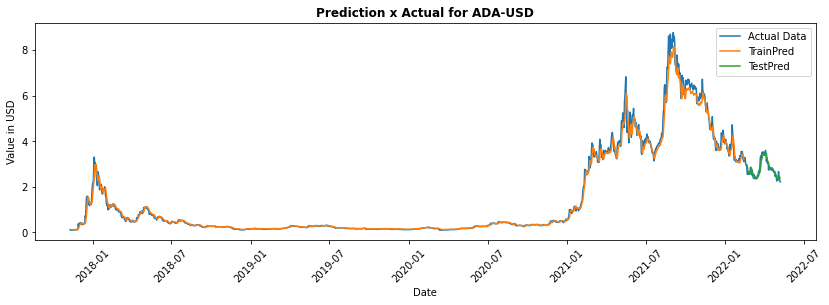


###### END OF PREDICTIONS FOR ADA-USD CRYPTO ######

###### PREDICTIONS FOR ATOM-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
1.5644599885423816


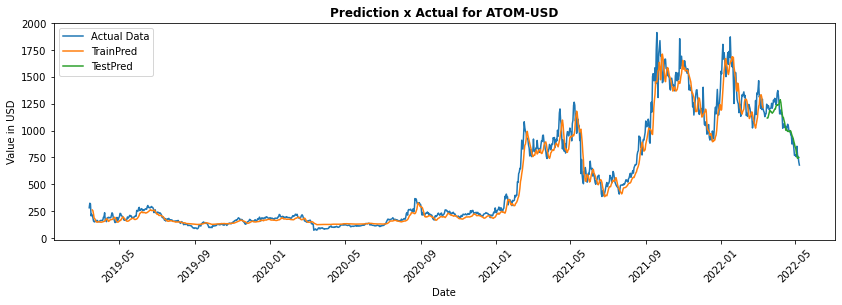


###### END OF PREDICTIONS FOR ATOM-USD CRYPTO ######

###### PREDICTIONS FOR AVAX-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
4.109513648743109


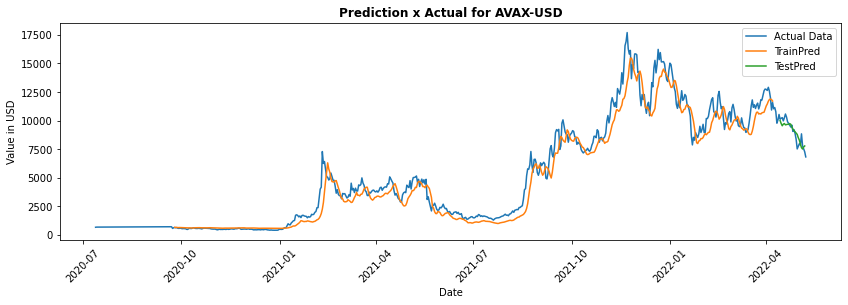


###### END OF PREDICTIONS FOR AVAX-USD CRYPTO ######

###### PREDICTIONS FOR AXS-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
3.2214366100407736


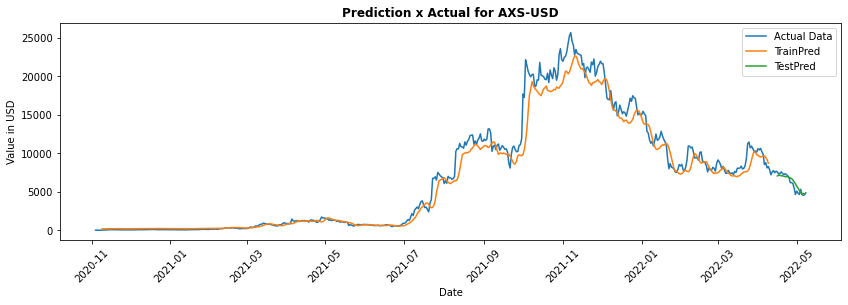


###### END OF PREDICTIONS FOR AXS-USD CRYPTO ######

###### PREDICTIONS FOR BTC-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
1392.384622676866


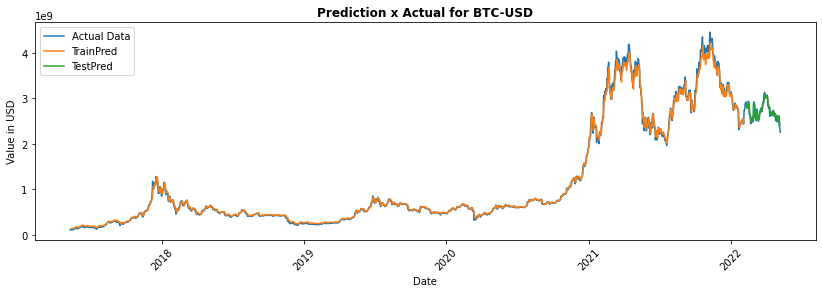


###### END OF PREDICTIONS FOR BTC-USD CRYPTO ######

###### PREDICTIONS FOR ETH-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
113.04382890558257


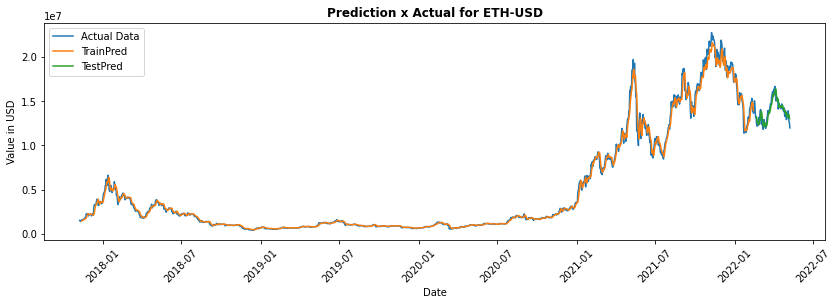


###### END OF PREDICTIONS FOR ETH-USD CRYPTO ######

###### PREDICTIONS FOR LINK-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
0.6360043373579881


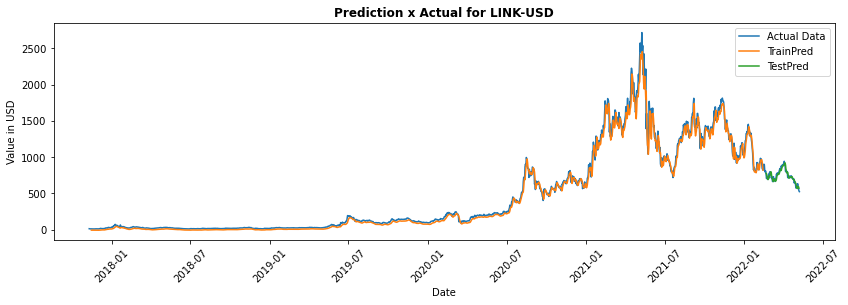


###### END OF PREDICTIONS FOR LINK-USD CRYPTO ######

###### PREDICTIONS FOR LUNA1-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
8.607751887141664


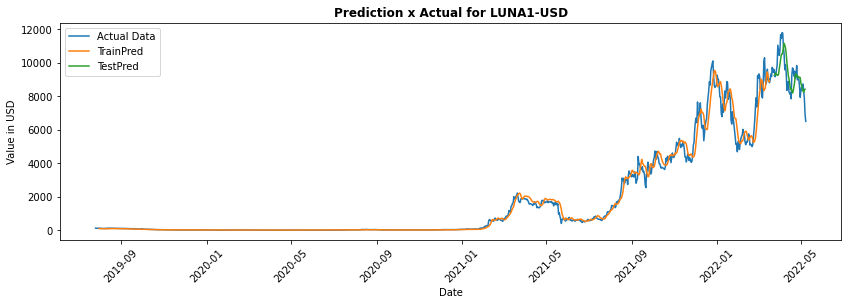


###### END OF PREDICTIONS FOR LUNA1-USD CRYPTO ######

###### PREDICTIONS FOR MATIC-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
0.057769392440061136


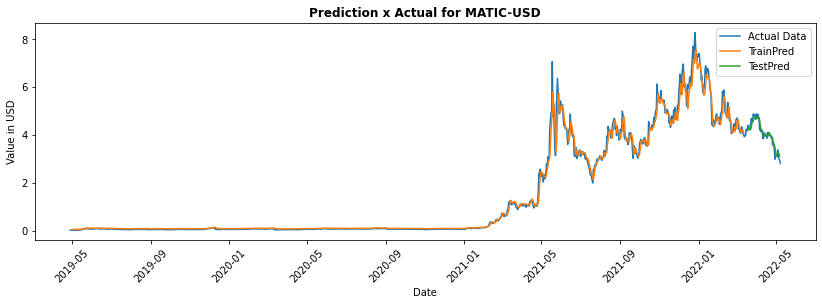


###### END OF PREDICTIONS FOR MATIC-USD CRYPTO ######

###### PREDICTIONS FOR SOL-USD CRYPTOCURRENCY ######

Running epochs now, it might take a while
5.48282466452743


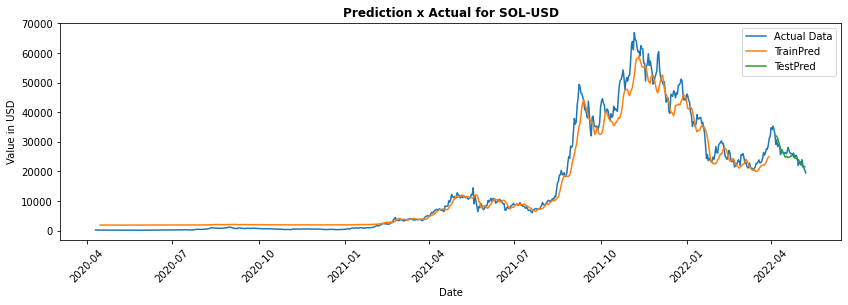


###### END OF PREDICTIONS FOR SOL-USD CRYPTO ######



In [179]:
#Create a dictionary with names and predictions for all coins. Parameters used: prediction based on last 15 days, 100 epochs.
crypto_predictions = {}
rmse_scores = []
for key,value in crypto_names.items():
    crypto_predictions[f'{key}'] = predict_coin(key,value,days=5,epochs=200).tolist()


In [182]:
data = pd.DataFrame()

day1 = []
day2 = []
k=0
while k<len(list(crypto_predictions.values())):
    day1.append((list(crypto_predictions.values())[k][0])[0])
    k=k+1
k=0    
while k<len(list(crypto_predictions.values())):
    day2.append((list(crypto_predictions.values())[k][1])[0])
    k=k+1

data['Index'] = (list(crypto_names.keys()))
data['RMSE Score'] = rmse_scores
data['Pred - Day1'] = day1
data['Pred - Day2'] = day2
data.set_index('Index', inplace=True)

In [183]:
data

,RMSE Score,Pred - Day1,Pred - Day2
Index,,,
ADA-USD,0.051249,0.762156,0.755748
ATOM-USD,1.564460,17.556238,16.574033
AVAX-USD,4.109514,58.261515,54.822915
AXS-USD,3.221437,29.513426,28.479480
BTC-USD,1392.384623,35025.883233,35111.116047
ETH-USD,113.043829,2628.568599,2604.871957
LINK-USD,0.636004,9.988089,9.811246
LUNA1-USD,8.607752,79.333446,75.532803
MATIC-USD,0.057769,1.011939,1.009481


In [185]:
data.to_csv('lstm.csv')